# Modeling System Resource Usage for Predictive Scheduling

## Data Science Consulting Project with [Manifold.co](manifold.co)

### Using time series and machine learning

In [271]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pandas import read_csv, datetime
from pandas.tools.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.linear_model import LassoCV, RidgeCV
from itertools import product                    
from tqdm import tqdm_notebook
import matplotlib.dates as mdates
%matplotlib inline

import warnings                                
warnings.filterwarnings('ignore')


## Read in data

In [166]:
path = r'rnd/2013-7/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join 
df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file)

In [167]:
path = r'rnd/2013-8/'                     
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
concatenated_df8   = pd.concat(df_from_each_file)

In [168]:
path = r'rnd/2013-9/'                   
all_files = glob.glob(os.path.join(path, "*.csv"))  
df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
concatenated_df9   = pd.concat(df_from_each_file)

## Create Data Frame

In [169]:
newdat = concatenated_df.append(concatenated_df8)
newerdat = newdat.append(concatenated_df9)
concatenated_df = newerdat

Check it out

In [264]:
concatenated_df.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],...,weekday,weekend,month,day,CPU usage prev,CPU_diff,received_prev,received_diff,transmitted_prev,transmitted_diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2013-06-30 22:03:24,1372629804,2,5851.9989,87.779984,1.500000,8218624.0,1.034593e+06,160.866667,21.733333,0.266667,...,6,1.0,6,30,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-30 22:08:24,1372630104,2,5851.9989,29.259995,0.500000,8218624.0,4.585755e+05,0.000000,2.333333,0.200000,...,6,1.0,6,30,1.500000,-1.000000,0.266667,-0.066667,1.466667,-0.466667
2013-06-30 22:13:24,1372630404,2,5851.9989,27.309328,0.466667,8218624.0,1.845480e+05,32.066667,4.200000,0.133333,...,6,1.0,6,30,0.500000,-0.033333,0.200000,-0.066667,1.000000,0.066667
2013-06-30 22:18:24,1372630704,2,5851.9989,23.407996,0.400000,8218624.0,7.829227e+04,0.000000,0.866667,0.066667,...,6,1.0,6,30,0.466667,-0.066667,0.133333,-0.066667,1.066667,-0.066667
2013-06-30 22:23:24,1372631004,2,5851.9989,19.506663,0.333333,8218624.0,1.677720e+05,0.000000,0.200000,0.133333,...,6,1.0,6,30,0.400000,-0.066667,0.066667,0.066667,1.000000,0.000000


## Feature engineering and converting pandas into a timeseries
Timestamp is in UNIX epochs

In [171]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
concatenated_df.apply(pd.to_numeric, errors='ignore')

# Date Feature Engineering
concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek
concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)

# Other Feature Engineering
concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]
concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]

## Fill in missing values using forward propagating function from pandas

In [176]:
concatenated_df = concatenated_df.fillna(method='ffill')

## Create new data frame: resampled & aggregated over each hour for all VMs. This allowed me to get a broader picture of the network's activity. 

In [177]:
hourlydat = concatenated_df.resample('H').sum()

In [178]:
# Save to .csv
#hourlydat.to_csv('hourlydat.csv', sep = ',')

## Examine autocorrelations of hourly transmitted, received, and CPU usage

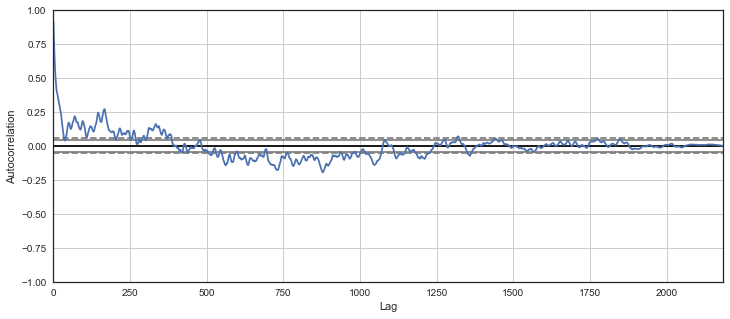

In [277]:
## Hourly resampled means
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(hourlydat['CPU usage [MHZ]']);

## Is CPU Capacity Ever Met? If so, how often?

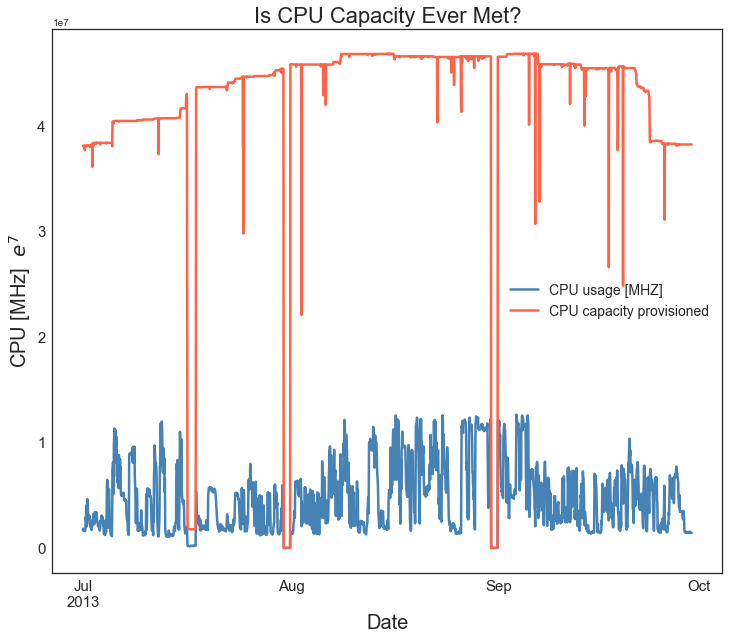

In [415]:
overprovision = pd.DataFrame(hourlydat['CPU usage [MHZ]'])
overprovision['CPU capacity provisioned'] = pd.DataFrame(hourlydat['CPU capacity provisioned [MHZ]'])
#overprovision.to_csv("overprovision.csv", sep = ",")

plt.style.use('seaborn-white')
overprovision.plot(figsize = (12,10),linewidth=2.5,colors = ['steelblue','tomato'],fontsize=20)
plt.title('Is CPU Capacity Ever Met?',fontsize=22)
plt.ylabel((r'CPU [MHz]  $e^{7}$'), fontsize=20);
plt.xlabel('Date', fontsize=20);
plt.tick_params(labelsize=15)
plt.xticks( fontsize = 15)
plt.legend(loc="best", fontsize =14)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (1,6))
plt.savefig('CPU_cap_under.png')
plt.show()

one month view for clarity and presentation

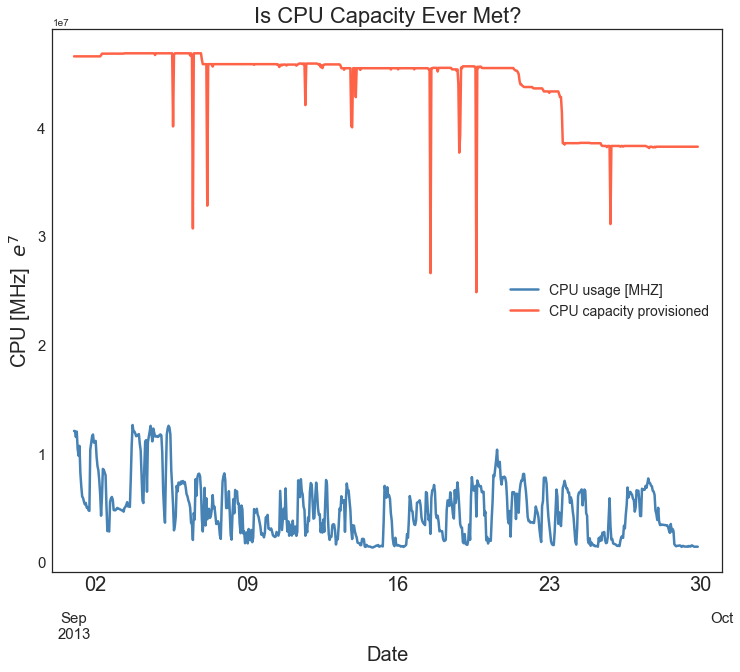

In [414]:
plt.style.use('seaborn-white')
overprovision[(overprovision.index > '2013-08-31 23:59:00') & (overprovision.index < '2013-10-01 0:00:00')].plot(figsize = (12,10),linewidth=2.5,colors = ['steelblue','tomato'],fontsize=20)
plt.title('Is CPU Capacity Ever Met?',fontsize=22)
plt.ylabel((r'CPU [MHz]  $e^{7}$'), fontsize=20);
plt.xlabel('Date', fontsize=20);
plt.tick_params(labelsize=15)
plt.xlim([datetime.date(2013, 8, 31), datetime.date(2013, 10, 1)])
plt.xticks( fontsize = 15)
plt.legend(loc="best", fontsize =14)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (1,6))
plt.savefig('CPU_cap_under_1mo.png')
plt.show()

## What might cause over provision? Spikes in Network throughput? 

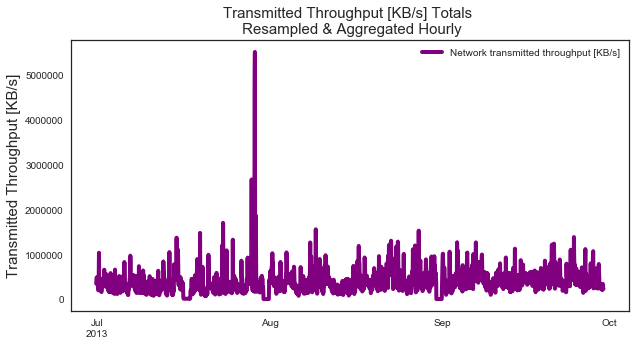

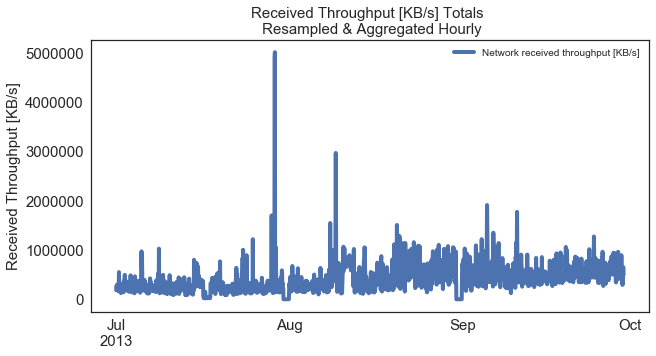

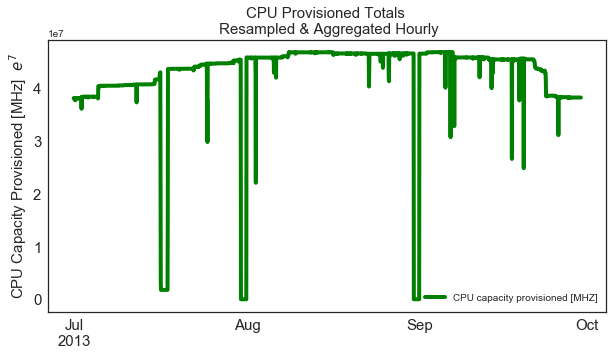

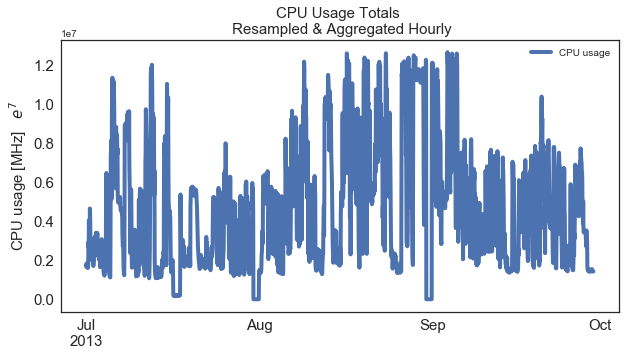

In [188]:
hourlytransmit.plot(color = "purple",linewidth = 4,  figsize=(10, 5))
plt.title('Transmitted Throughput [KB/s] Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('Transmitted Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);

hourlyreceive.plot( linewidth = 4, figsize=(10, 5))
plt.title('Received Throughput [KB/s] Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('Received Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlyprov.plot(color = "g", linewidth = 4, figsize=(10, 5))
plt.title('CPU Provisioned Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('CPU Capacity Provisioned [MHz]  $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlycpu.plot(linewidth = 4, figsize=(10, 5))
plt.title('CPU Usage Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('CPU usage [MHz]   $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

In [190]:
print("The Average CPU Percent Usage is only: " + str(round(concatenated_df['CPU usage [%]'].mean(),2)) + "%!!")
print("The Minimum CPU Percent Usage is: " + str(round(concatenated_df['CPU usage [%]'].min(),2)) + "%!!")
print("The Maximum CPU Percent Usage is: " + str(round(concatenated_df['CPU usage [%]'].max(),2)) + "%, possibly inidcating the system crashed?")

The Average CPU Percent Usage is only: 6.01%!!
The Minimum CPU Percent Usage is: 0.0%!!
The Maximum CPU Percent Usage is: 182.13%, possibly inidcating the system crashed?


### Importing modeling metrics 

In [74]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Plot moving averages, window = 24 (hours in a day). 

## Moving averages smooth the data so we can observe trends/patterns in the data. 

### Looks like this method caught some anomalies. Keeping anomalies (outliers) in model.

In [75]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


In [452]:
## FUNCTION TO PLOT MOVING AVG
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.style.use('seaborn-white')
    plt.figure(figsize=(15,7))
    plt.title("Moving Average (window size = {})".format(window), fontsize = 20)
    plt.ylabel('CPU usage [MHz]   $e^{7}$', fontsize=16);
    plt.xlabel('Time', fontsize=16);
    plt.yticks(fontsize=15);
    plt.xticks(fontsize=15);
    plt.plot(rolling_mean, "purple", label="Rolling Mean Trend",linewidth = 5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper/Lower Bound", linewidth = 1)
        plt.plot(lower_bond, "r--", linewidth = 1)
        
        # find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10, label = "Anomalies")
        
    plt.plot(series[window:], label="Actual CPU Usage", linewidth = 1)
    plt.legend(loc="upper right", fontsize =13)
    plt.grid(True)

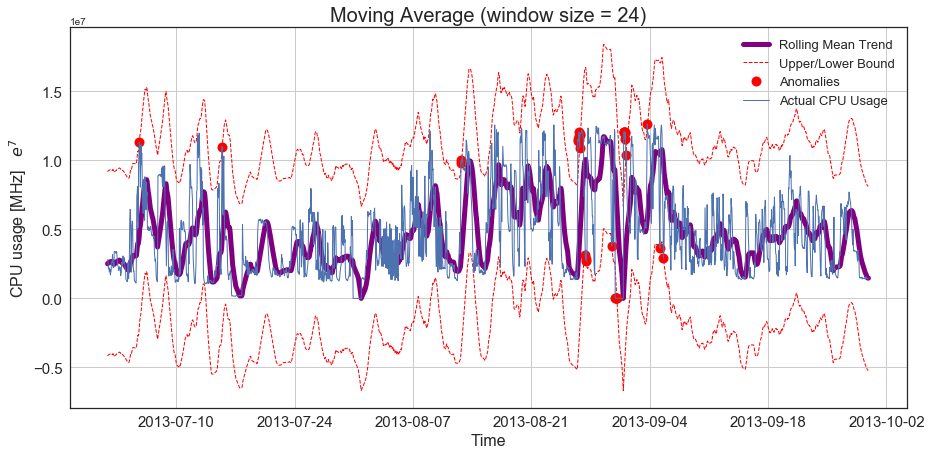

In [454]:
## make 24 hour windows
plotMovingAverage(hourlydat[['CPU usage [MHZ]']], 24, plot_intervals=True, plot_anomalies=True)

# Establish Stationarity

## Augmented Dickey-Fuller Test (more detail here, in [this blog](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3))

A p-value < 0.05 indicates that the time series IS STATIONARY.

## ADF test: CPU usage is stationary, p < .05.

In [269]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        plt.style.use('seaborn-white')
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

## Last figures suggest data has an hourly seasonality (24 hours) as indicated by spikes in AC and PAC plots for the residuals (at 24 and then 48 hours). 

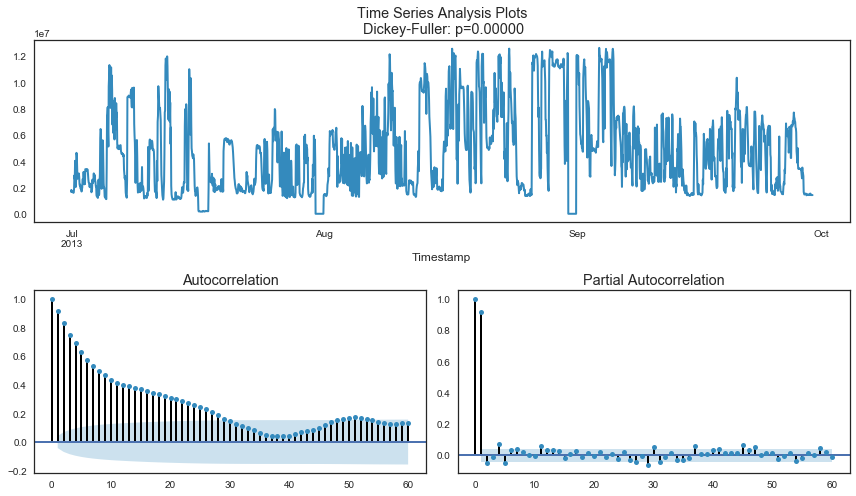

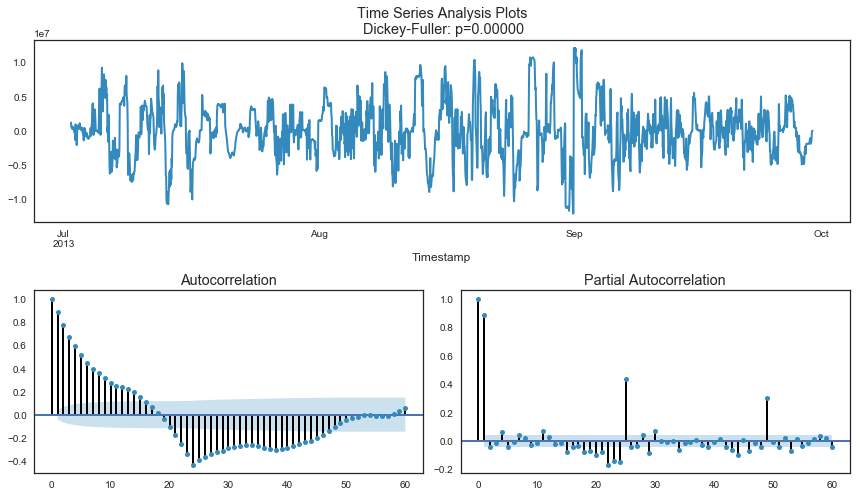

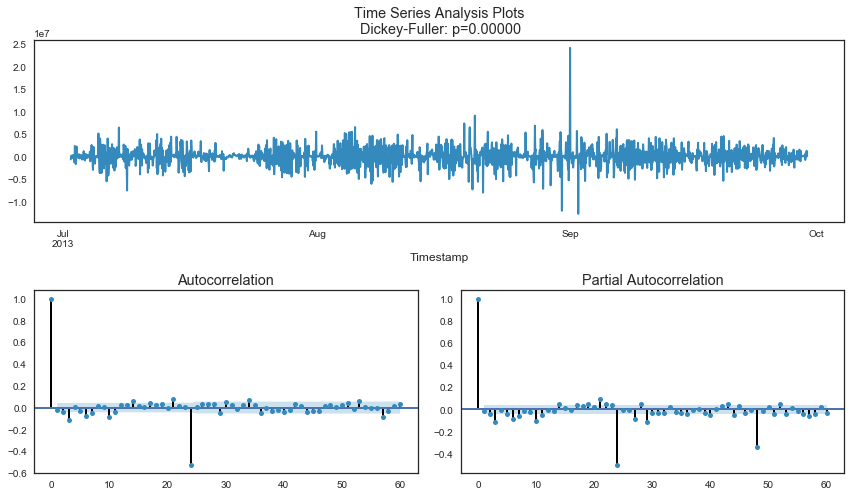

In [270]:
tsplot(hourlydat['CPU usage [MHZ]'], lags=60)
ads_diff = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift(24)
tsplot(ads_diff[24:], lags=60)
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

# Check autocorrelation in actual data- looks like we have a short term time series

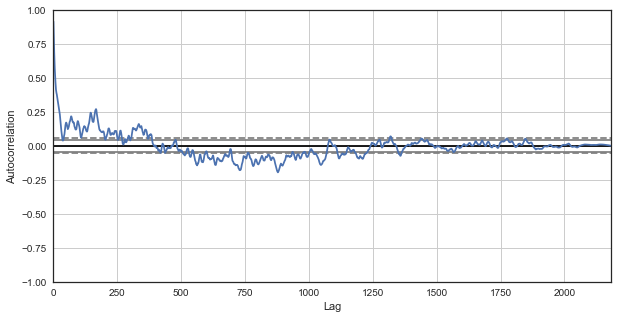

In [200]:
plt.figure(figsize=(10,5))
autocorrelation_plot(hourlydat['CPU usage [MHZ]']);
plt.show();

# MODELING

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

load function for ts train test split

In [374]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [375]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [376]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.tick_params(labelsize=20)
    plt.xlabel("Features", fontsize = 20) 
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

### Create training and testing data sets

In [459]:
data = pd.DataFrame(hourlydat['CPU usage [MHZ]'].copy())
data.columns = ["y"]

# Adding the lag of the target variable from 3 steps (hours) up to 24
for i in range(3, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

Note: I used MAE (mean absolute error) as my metric, but there are many others.

## Model Plot Function

In [460]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)

    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "orange", label="Prediction", linewidth=2.0)
    plt.plot(y_test.values,label="Actual Usage", linewidth=2.0)
    plt.plot(capprv.values, color='red',label = "Actual Provision")

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="Upper/Lower Bounds", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        plt.tick_params(labelsize=20)
        plt.ylabel("CPU usage [MHZ]", fontsize = 20)
        plt.xlabel("Time", fontsize = 20) 
        plt.yticks([2000000,6000000,12000000, 50000000])# customized for graph readability
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean Absolute Error: {0:.2f}%".format(error),  fontsize = 20)
    plt.legend(loc="best", fontsize = 15)
    plt.tight_layout()
    plt.grid(True);

## Linear Regession Model

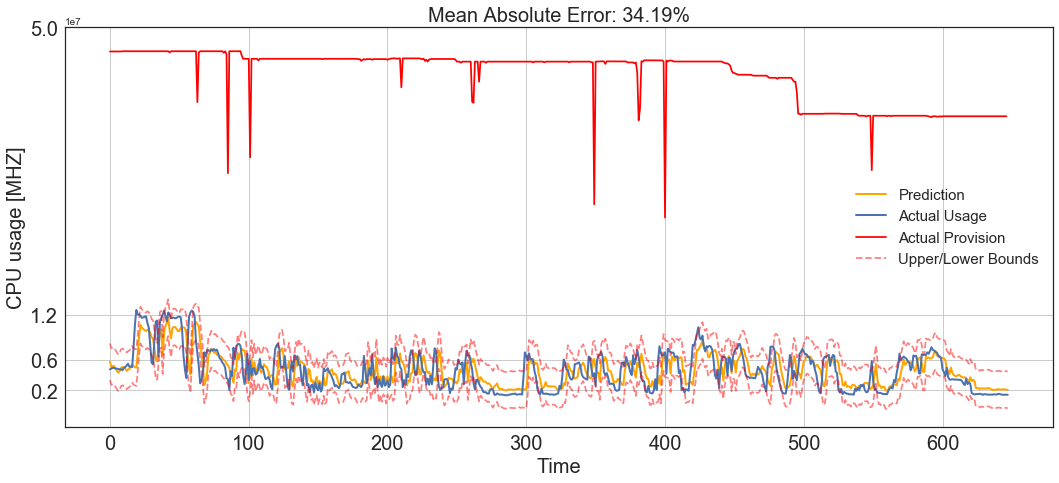

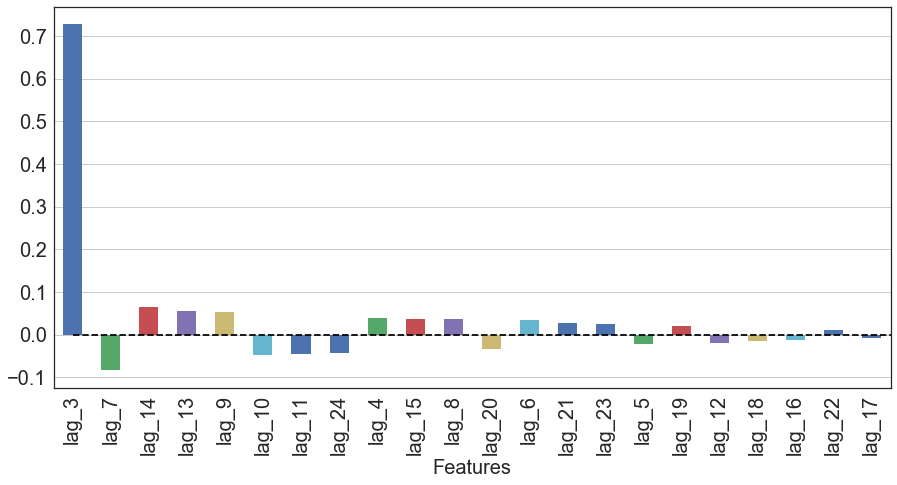

In [461]:
# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

#linear reg
model = LinearRegression()
model.fit(X_train, y_train)

plotModelResults(model, plot_intervals=True)
plotCoefficients(model)

## Feature Engineering (Date)

In [462]:
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

## Scaled Linear Regression with Added Features

### Function to plot Scaled models

In [463]:
def plotModelResultsScaler(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)

    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "orange", label="Prediction", linewidth=4.0)
    plt.plot(y_test.values,label="Actual Usage", linewidth=2.0)
    
    ## if you want to see what was actually provisioned, use the next line
    
    #plt.plot(capprv.values, color='red',label = "Actual Provision")
    
    plt.ylabel("CPU usage [MHZ]", fontsize = 20)
    plt.xlabel("Time", fontsize = 20) 
    #plt.yticks([2000000,6000000,12000000, 50000000]) # customized for graph readability 
    plt.tick_params(labelsize=20)
    plt.ylabel('CPU [MHz]  $e^{7}$', fontsize=20);
    plt.xlabel("Time", fontsize = 20) 
   
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "b--", label="Upper/Lower Bounds", alpha=0.5, linewidth=1)
        plt.plot(upper, "b--", alpha=0.5, linewidth=1)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean Absolute Error {0:.2f}%".format(error), fontsize = 20)
    plt.legend(loc="best", fontsize =15)
    plt.tight_layout()
    plt.grid(True);

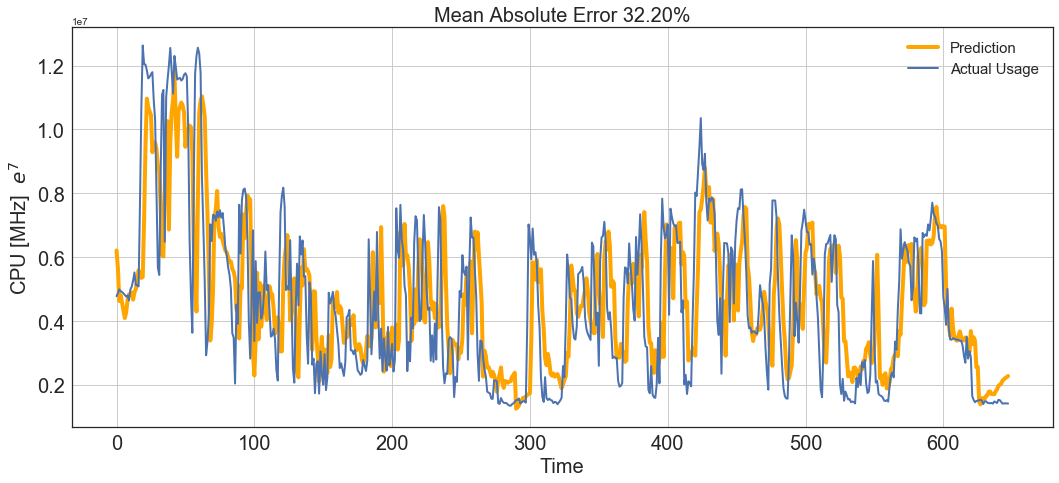

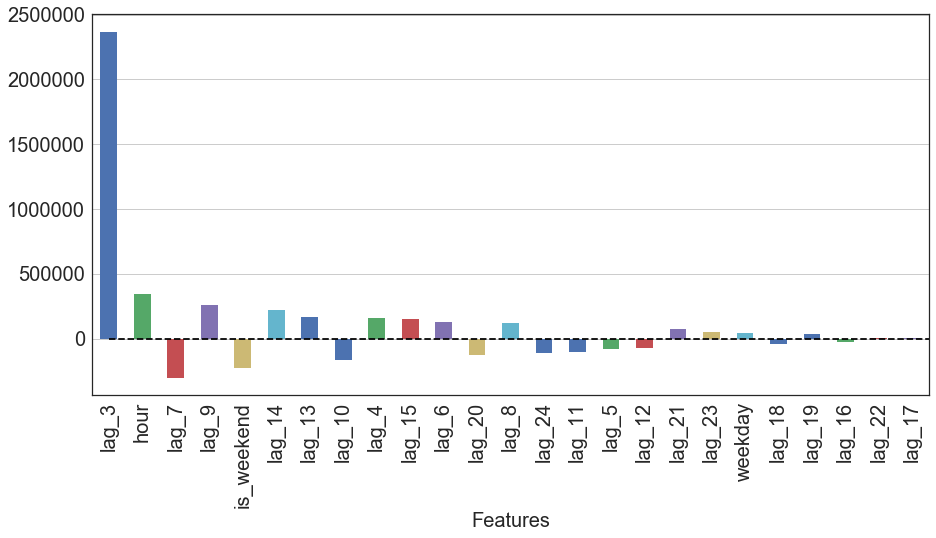

In [464]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr2 = LinearRegression()
lr2.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr2, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=False, plot_anomalies=False)
plotCoefficients(lr2)

## Function to prepare data for model with encoded features

In [465]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories
    and values are means
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries
        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today
        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today
        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    # other features
    data['network received'] = hourlydat[['Network received throughput [KB/s]']]
    data['network transmitted'] = hourlydat[['Network transmitted throughput [KB/s]']]
    data['cpu diff'] = hourlydat[['CPU_diff']]
    data['received_prev'] = hourlydat[['received_prev']]
    data['core'] = hourlydat[['CPU cores']]

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(
            code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(
            code_mean(data[:test_index], 'hour', "y").get, data.hour))
        
        # drop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test =\
    timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

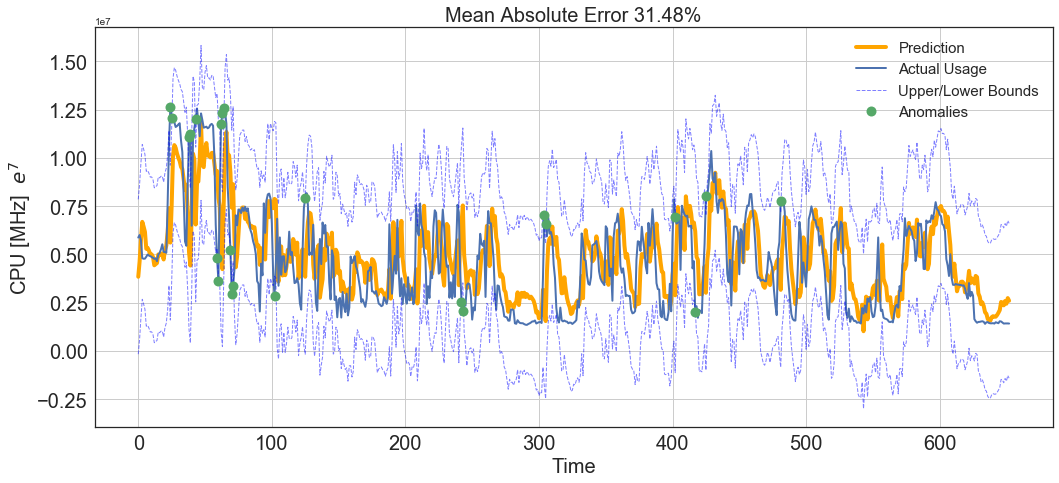

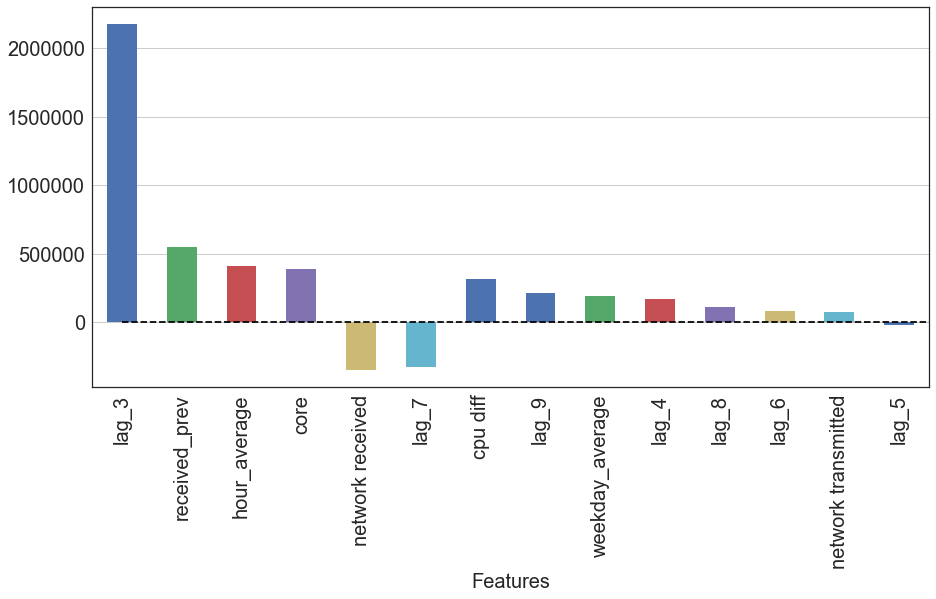

In [466]:
X_train, X_test, y_train, y_test =\
prepareData(hourlydat[['CPU usage [MHZ]']], lag_start=3, lag_end=10, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr, X_train=X_train_scaled, X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [467]:
X_train, X_test, y_train, y_test =\
prepareData(hourlydat['CPU usage [MHZ]'], lag_start=3, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Ridge (scaled) Regression: performs L2 regularization to prevent overfitting and find most important features

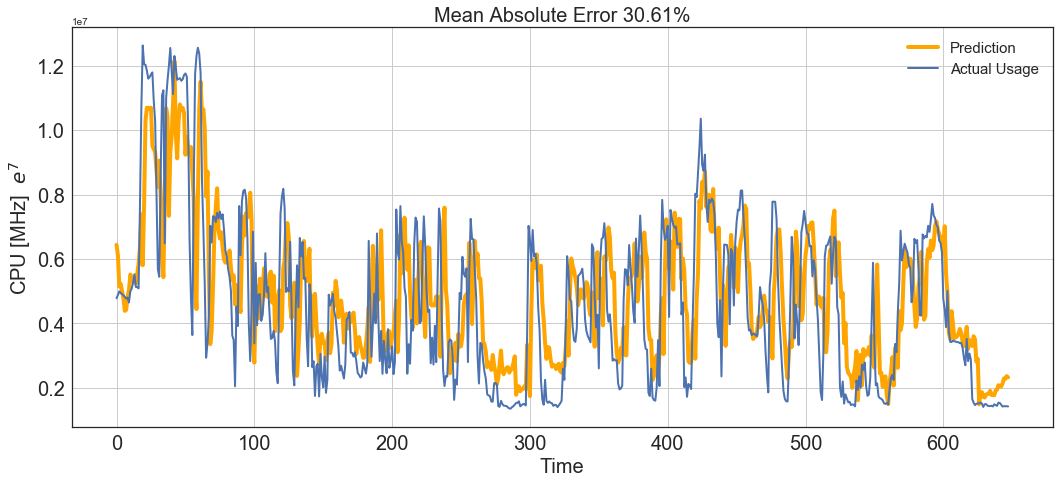

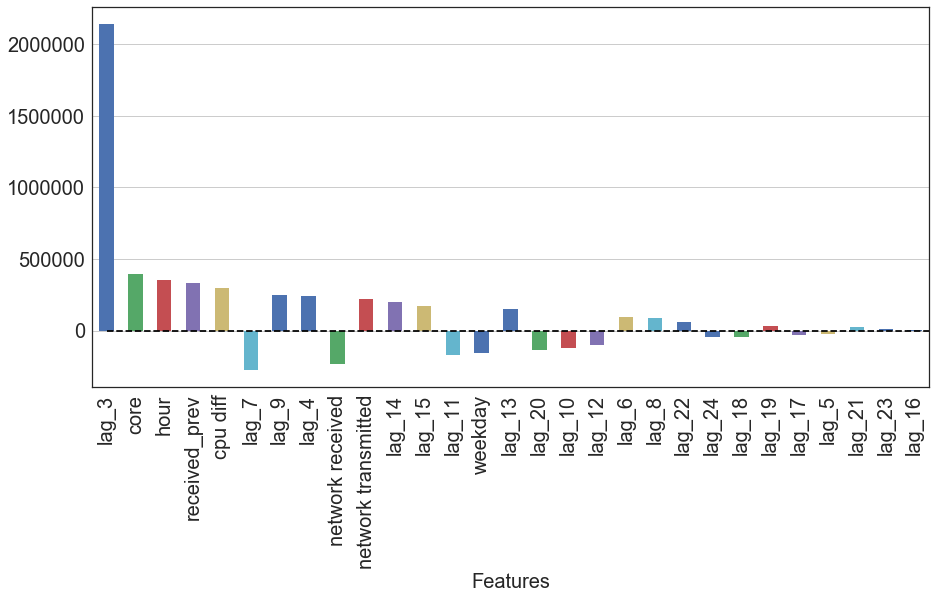

In [468]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResultsScaler(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=False, plot_anomalies=False)
plt.savefig('scaled_ridge_regression.png')

plotCoefficients(ridge)

## Lasso Regression: performs L1 regularization to prevent overfitting and find most important features

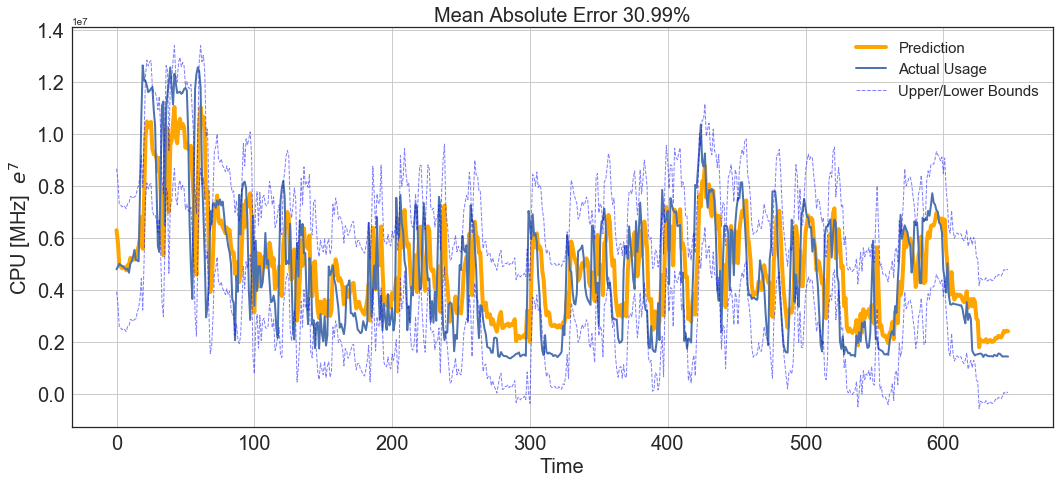

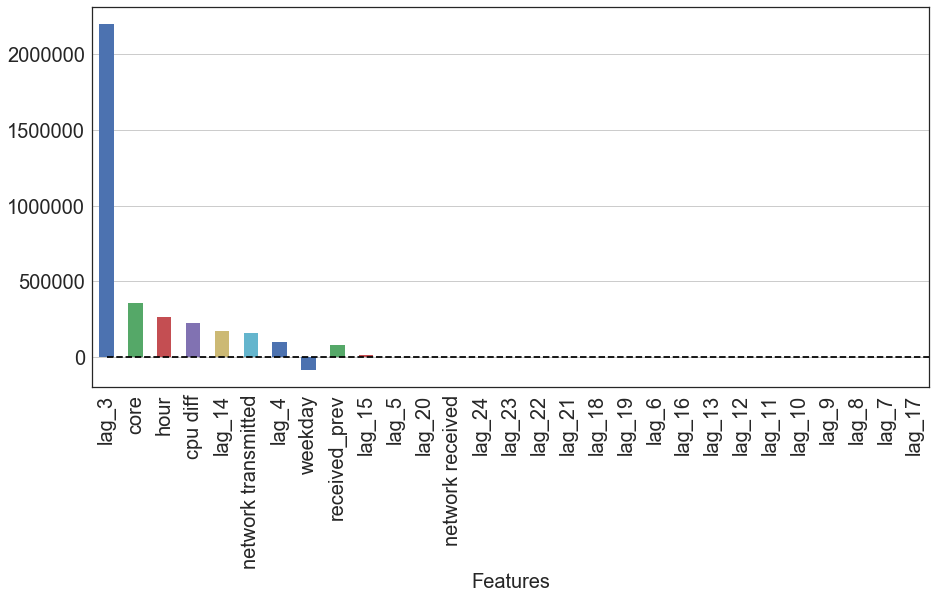

In [469]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResultsScaler(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=False)
plt.savefig('scaled_lasso_regression.png')
plotCoefficients(lasso)

In [470]:
### Next Steps: Recurrent Neural Net model on Amazon Sagemaker